<a href="https://colab.research.google.com/github/caiocfpeixoto/PDI/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

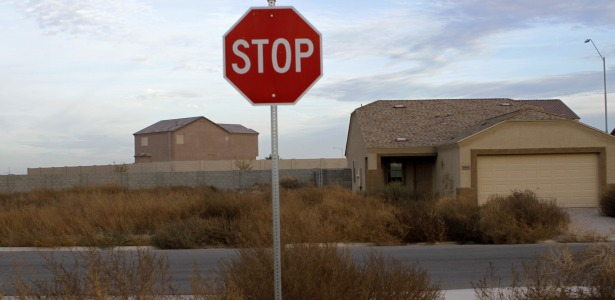

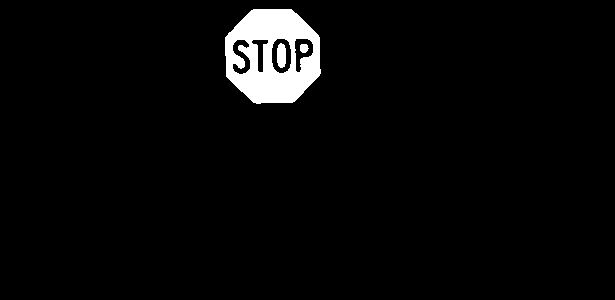

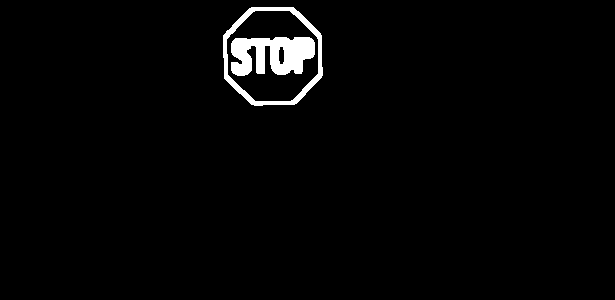

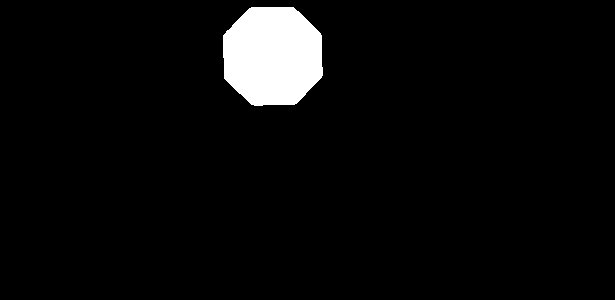

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def preprocess_image(image):
    # Aplicar borramento gaussiano para reduzir ruídos
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Converter imagem para o espaço de cores HSV
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # Definir intervalo de valores de matiz para tons de vermelho
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Criar máscara utilizando os intervalos definidos
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    return mask

def postprocess_image(image):
    # Aplicar filtro de Sobel para detecção de bordas
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.bitwise_or(np.absolute(sobelx), np.absolute(sobely))

    # Dilatar as bordas para juntar bordas de um mesmo objeto
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Preencher o interior de objetos conectados
    filled = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

    return filled

# Carregar imagem da placa de pare
image = cv2.imread('1.jpg')

# Pré-processamento
preprocessed_image = preprocess_image(image)

# Pós-processamento
postprocessed_image = postprocess_image(preprocessed_image)

sus = postprocessed_image + preprocessed_image
# Exibir imagem original, imagem pré-processada e imagem pós-processada
cv2_imshow(image)
cv2_imshow(preprocessed_image)
cv2_imshow(postprocessed_image)
cv2_imshow(sus)


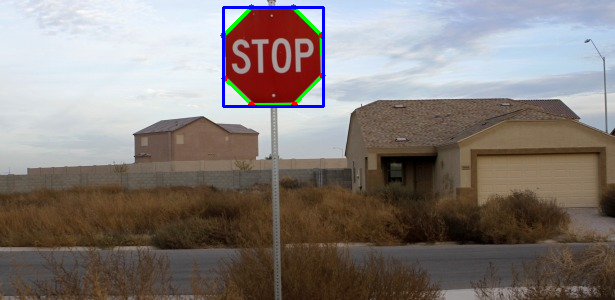

In [ ]:
# Encontrar os contornos na imagem segmentada
array = np.array(sus, np.uint8)
contornos, _ = cv2.findContours(array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Percorrer cada contorno
for contorno in contornos:
    # Aproximar o contorno por um polígono
    epsilon = 0.03 * cv2.arcLength(contorno, True)
    poligono = cv2.approxPolyDP(contorno, epsilon, True)

    # Verificar se o popolígono tem 6 vértices (hexágono)
    if len(poligono) >= 4 and len(poligono) <= 8:
        # Desenhar o contorno com retas e os vértices
        cv2.polylines(image, [poligono], True, (0, 255, 0), 2)  # Desenha as retas do contorno
        for ponto in poligono:
            x, y = ponto[0]
            cv2.circle(image, (x, y), 3, (0, 0, 255), -1)  # Marca os pontos dos vértices com círculos vermelhos

        # Obter as coordenadas do retângulo delimitador do contorno
        x, y, largura, altura = cv2.boundingRect(contorno)

        # Desenhar o retângulo delimitador
        cv2.rectangle(image, (x, y), (x + largura, y + altura), (255, 0, 0), 2)  # Desenha o retângulo delimitador em azul

# Exibir a imagem com o contorno, os vértices e o retângulo
cv2_imshow(image)